In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
import matplotlib.colors as clr
from scipy.stats import gaussian_kde
import scipy.sparse as sp


warnings.filterwarnings("ignore")

Load in the adata

In [18]:
# Load in adata
adata = sc.read_h5ad('/mnt/sata1/Dhruv_Analysis_1/2025_10_31_Clone13/combined/final_adata.h5ad')

adata.obs['Subtype'] = adata.obs['resolvi_predicted']

# Normalize and log transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Filter cells for Xist expression and P14 & ab+ Cd8 T cells
gidx = adata.var_names.get_loc('Xist')
X = adata.X
if sp.issparse(X):
    mask = X[:, gidx].toarray().ravel() > 0
else:
    mask = X[:, gidx] > 0

adata_xist = adata[mask].copy()
print(adata.obs.shape)
print(adata_xist.obs.shape)

p14_ab_Xist_adata = adata_xist[adata_xist.obs['Subtype'].isin(['Cd8_T-Cell_P14', 'Cd8_T-Cell_ab+'])]

(674090, 34)
(7422, 34)


In [19]:
# Check cell type filtering
p14_ab_Xist_adata.obs["Subtype"].value_counts()

Subtype
Cd8_T-Cell_P14    1327
Cd8_T-Cell_ab+     492
Name: count, dtype: int64

In [20]:
# Set custom colormap

zissou = [
    "#3A9AB2",
    "#6FB2C1",
    "#91BAB6",
    "#A5C2A3",
    "#BDC881",
    "#DCCB4E",
    "#E3B710",
    "#E79805",
    "#EC7A05",
    "#EF5703",
    "#F11B00",
]

colormap = clr.LinearSegmentedColormap.from_list("Zissou", zissou)
colormap_r = clr.LinearSegmentedColormap.from_list("Zissou", zissou[::-1])

In [21]:
# Manually set batches, what are the x and y?
batches = {
    "batch_1": {"x": 6200, "y": 6200},
    "batch_2": {"x": 5800, "y": 5500},
}

In [22]:
# Functions to help with the IMAPS
def scatter_with_gaussian_kde_weights(ax, x, y, weights, **kwargs):
    """
    Plots a scatter plot colored by gaussian kde estimates.

    Parameters:
    - ax (matplotlib ax): The ax on which to plot the scatter plot.
    - x (np.array): The x values to perform the gaussian kde and scattering on.
    - y (np.array): The y values to perform the gaussian kde and scattering on.
    - weights (np.array): The weights to use for the gaussian kde.
    - **kwargs: Additional keyword arguments to pass to the scatter function.

    Returns:
    - None
    """

    xy = np.vstack([x, y])
    z = gaussian_kde(xy, weights=weights)(xy)

    ax.scatter(x, y, c=z, **kwargs)


# Custom biexponential transformation. Returns x coordinates that have been transformed
def transformation(x, a=0.1, b=0.1, c=0.5, d=2.5, f=4, w=1):
    x = np.array(x)
    return a * np.exp(b * ((x - w))) - c * np.exp(-d * (x - w)) + f


def draw_gates(ax, gates, transformation, type="edge"):
    """
    Draws IMAP gates on a matplotlib ax.

    Parameters:
    - ax (matplotlib ax): The ax on which to draw the gates.
    - gates (dict): A dictionary containing the gates to draw.
    - transformation (function): A function to transform the x values of the gates.
    - type (str): The type of gate to draw. Can be "fill" or "edge".

    Returns:
    - None
    """
    from matplotlib.patches import Polygon

    for gate in gates:
        # Apply transformation to x values
        points = [
            [transformation(element[0])] + element[1:]
            for element in gates[gate]["edges"]
        ]

        if type == "fill":
            p = Polygon(points, facecolor=gates[gate]["fill"], edgecolor="none")
            ax.add_patch(p)
        elif type == "edge":
            p = Polygon(points, facecolor="none", edgecolor="#222222")
            ax.add_patch(p)

            ax.text(
                transformation(gates[gate]["label_position"]["x"]),
                gates[gate]["label_position"]["y"],
                gate,
                fontsize=6,
                color="#222222",
            )

In [23]:
# Coordinates of the gates for Top LP, Crypt LP, Top IE, and Crypt IE
gates = {
    "Top IE": {
        "edges": [
            [0.055, 0.555],
            [0.295, 0.555],
            [0.295, 1.03],
            [0.055, 1.03],
        ],
        "label_position": {"x": 0.1, "y": 0.9},
        "fill": "#3A9AB244",
        "stroke": "#3A9AB2",
    },
    "Crypt IE": {
        "edges": [
            [0.055, 0.545],
            [0.295, 0.545],
            [0.295, 0.15],
            [0.055, 0.15],
        ],
        "label_position": {"x": 0.1, "y": 0.3},
        "fill": "#F11B0044",
        "stroke": "#F11B00",
    },
    "Top LP": {
        "edges": [
            [0.305, 0.555],
            [6, 0.555],
            [6, 1.03],
            [0.305, 1.03],
        ],
        "label_position": {"x": 0.5, "y": 0.9},
        "fill": "#F0FEFF44",
        "stroke": "#F0FEFF",
    },
    "Crypt LP": {
        "edges": [
            [0.305, 0.545],
            [6, 0.545],
            [6, 0.295],
            [0.335, 0.15],
            [0.305, 0.15]
        ],
        "label_position": {"x": 0.5, "y": 0.3},
        "fill": "#F7DDDA44",
        "stroke": "#F7DDDA",
    },
    "Muscularis": {
        "edges": [
            [0.34, 0.15], 
            [6, 0.29], 
            [6, .15], 
        ],
        "label_position": {"x": 0.6, "y": 0.2},
        "fill": "#BDC88155",
        "stroke": "#BDC881",
    },
}

In [24]:
# Function to plot IMAPs
def plot_imaps(
    adata,
    batches,
    genes,
    ax_ticks=[0.15, 0.3, 0.6, 1, 6],
    transformation=transformation,
    gates=gates,
    dpi=100,
):
    """
    Plots IMAPs for a given set of batches and genes.

    Parameters:
    - adata (anndata): The anndata object containing the cells to plot.
    - batches (list): A list of batches to plot.
    - genes (list): A list of genes to weight the IMAPs by
    - ax_ticks (list): A list of x-axis ticks.
    - transformation (function): A function to transform the x values of the gates.
    - gates (dict): A dictionary containing the gates to plot.
    - dpi (int): The dpi of the plot.

    Returns:
    - None
    """
    fig = plt.figure(figsize=(3 * len(genes), 3 * len(batches)), dpi=dpi)

    # Apply transformation
    adata.obs["epithelial_distance_transformed"] = transformation(
        adata.obs["epithelial_distance"]
    )

    for col, gene in enumerate(genes):
        print("Plotting value: " + str(gene))
        # Iterate over batches
        for i, bt in enumerate(batches):
            sub_adata = adata[adata.obs["batch"] == bt]

            if gene == "Distribution":
                gene_expression = np.ones(len(sub_adata))
            else:
                gene_expression = np.array(
                    sub_adata[:, sub_adata.var.index == gene].X.flatten()
                )

            ax = fig.add_subplot(len(batches), len(genes), i * len(genes) + 1 + col)

            # Draw gates filled in background
            draw_gates(ax, gates=gates, transformation=transformation, type="fill")

            # Draw the density lines
            sns.kdeplot(
                data=sub_adata.obs,
                x="epithelial_distance_transformed",
                y="crypt_villi_axis",
                ax=ax,
                weights=gene_expression,
                color="#444444",
                linewidths=0.5,
            )

            # Colored scatter plot
            scatter_with_gaussian_kde_weights(
                ax=ax,
                x=sub_adata.obs["epithelial_distance_transformed"],
                y=sub_adata.obs["crypt_villi_axis"],
                weights=gene_expression,
                s=5,
                cmap="viridis" if gene == "Distribution" else colormap,
            )

            # Transform the tick labels and set them
            ax.set_xticks(transformation(ax_ticks))
            ax.set_xticklabels(ax_ticks)

            # Label the axes
            ax.set_xlabel("Epithelial Axis")
            ax.set_ylabel("Crypt-Villi Axis")

            ax.set_ylim(-0.02, 1.05)

            # Add a title
            if i == 0:
                ax.set_title(f"{gene}")
            else:
                ax.set_title(f"")
            draw_gates(ax, gates=gates, transformation=transformation)

    fig.tight_layout()

Plotting value: Gzma
Plotting value: Gzmb
Plotting value: Itgae
Plotting value: Tcf7


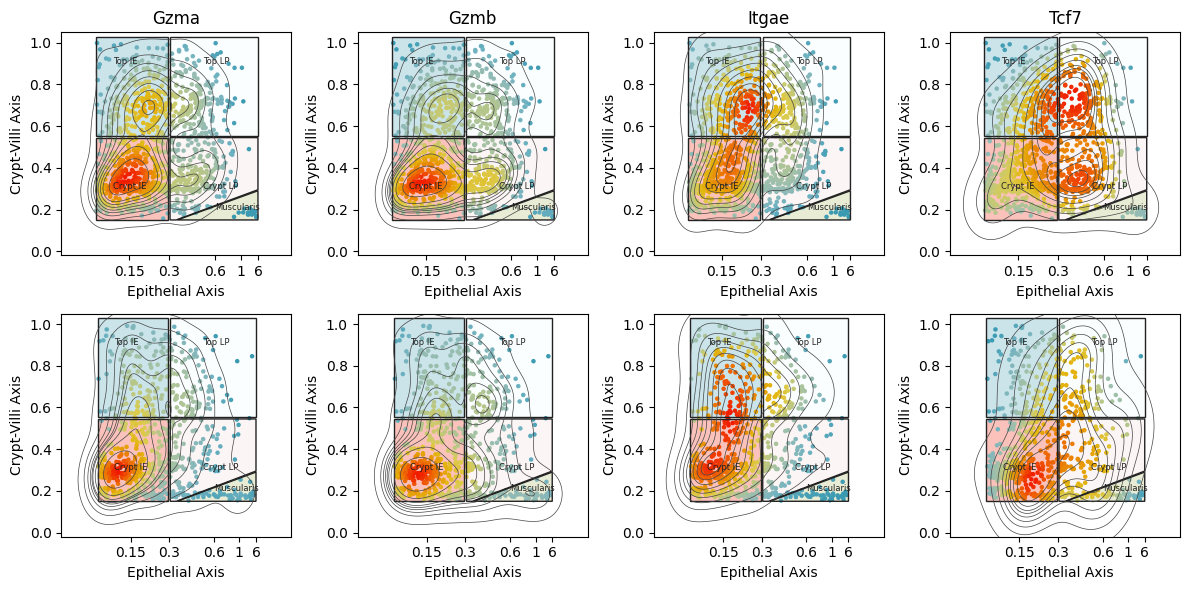

In [25]:
# Plot IMAPs to show P14 & ab+ Cd8 T cells localization
plot_imaps(
    p14_ab_Xist_adata,
    ["batch_1", "batch_2"],
    genes=["Gzma", "Gzmb", "Itgae", "Tcf7"],
)

Plotting value: Il7r


Plotting value: Srebf2
Plotting value: Ifngr2
Plotting value: Pdcd1


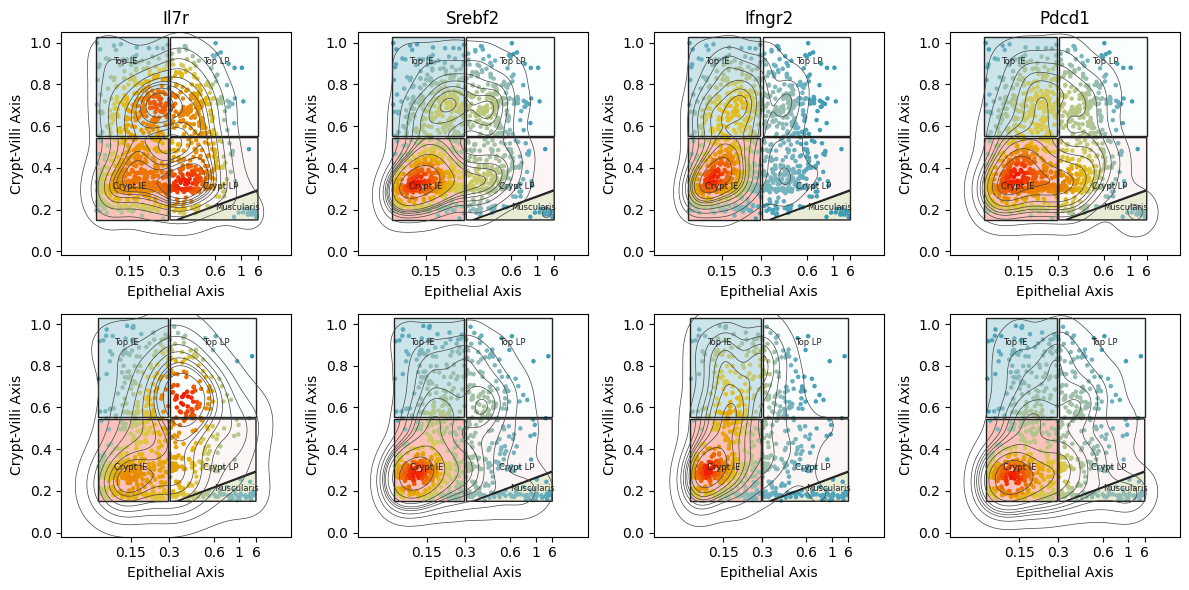

In [26]:
plot_imaps(
    p14_ab_Xist_adata,
    ["batch_1", "batch_2"],
    genes=["Il7r", "Srebf2", "Ifngr2", "Pdcd1"],
)

interest in if Xcr1 is expressed in p14

In [27]:
# exhaustion markers
exhaustion_genes = ['Lag3', 'Tim3', 'Slamf6']
candidates = exhaustion_genes.copy()
for gene in candidates:
    if gene not in p14_ab_Xist_adata.var_names:
        exhaustion_genes.remove(gene)
exhaustion_genes

# tpex markers
tpex_genes = ['Il2', 'Tnf', 'Pdcd1', 'Tcf7', 'Slamf6']
candidates = tpex_genes.copy()
for gene in candidates:
    if gene not in p14_ab_Xist_adata.var_names:
        tpex_genes.remove(gene)
tpex_genes

# tex markers
tex_genes = ['Ifng', 'Gzma', 'Gzmb', 'Pdcd1', 'Tim3', 'Tigit', 'Tox']
candidates = tex_genes.copy()
for gene in candidates:
    if gene not in p14_ab_Xist_adata.var_names:
        tex_genes.remove(gene)
tex_genes

print('exhaustion genes: ' + str(exhaustion_genes))
print('tpex genes: ' + str(tpex_genes))
print('tex genes: ' + str(tex_genes))


exhaustion genes: ['Lag3', 'Slamf6']
tpex genes: ['Il2', 'Pdcd1', 'Tcf7', 'Slamf6']
tex genes: ['Ifng', 'Gzma', 'Gzmb', 'Pdcd1']


### Exhaustion Genes

Plotting value: Lag3


Plotting value: Slamf6


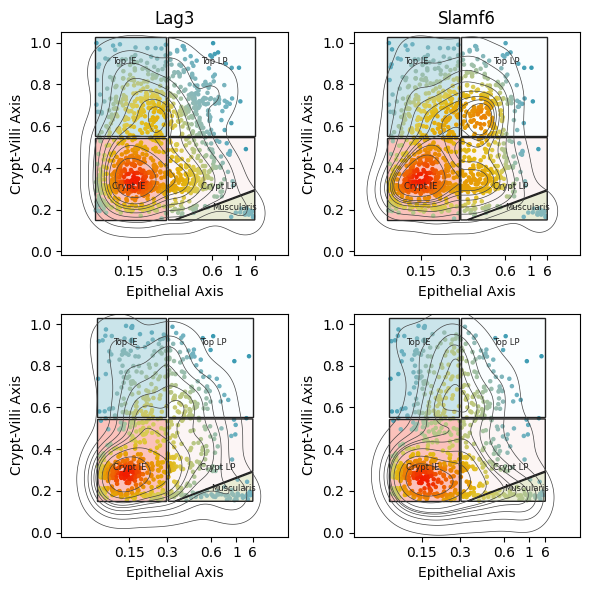

In [28]:
# Plot IMAPs to show P14 & ab+ Cd8 T cells localization
plot_imaps(
    p14_ab_Xist_adata,
    ["batch_1", "batch_2"],
    genes=exhaustion_genes,
)

### Tpex Genes

Plotting value: Il2


IndexError: cannot do a non-empty take from an empty axes.

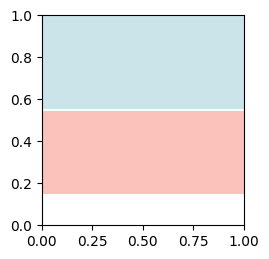

In [29]:
# Plot IMAPs to show P14 & ab+ Cd8 T cells localization
plot_imaps(
    p14_ab_Xist_adata,
    ["batch_1", "batch_2"],
    genes=tpex_genes,
)

### Tex Genes

Plotting value: Ifng
Plotting value: Gzma
Plotting value: Gzmb
Plotting value: Pdcd1


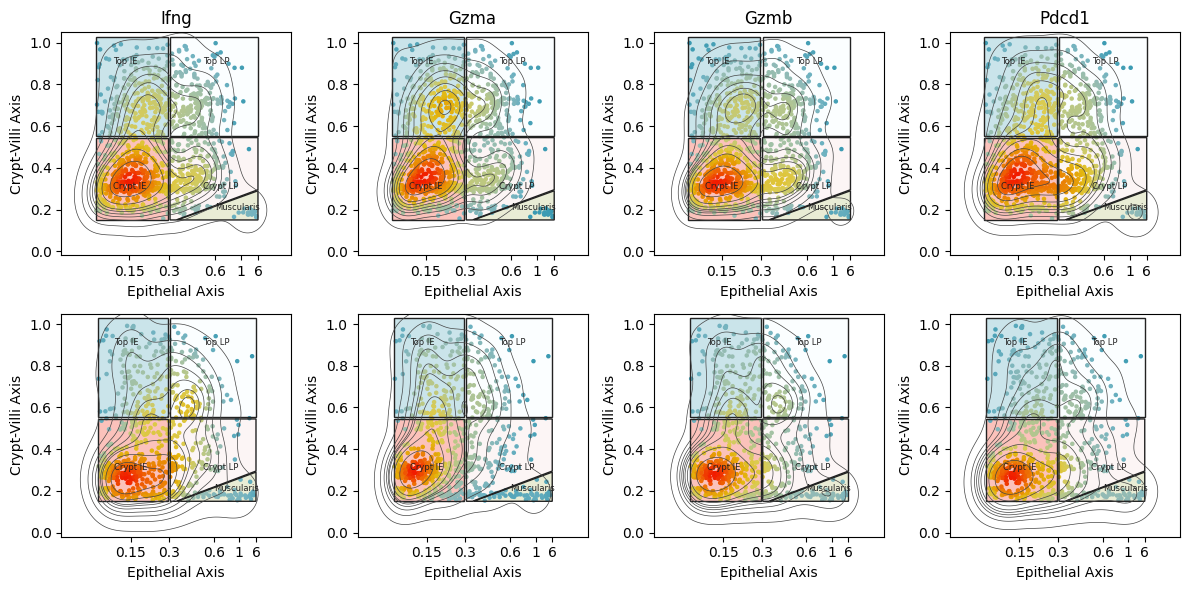

In [30]:
# Plot IMAPs to show P14 & ab+ Cd8 T cells localization
plot_imaps(
    p14_ab_Xist_adata,
    ["batch_1", "batch_2"],
    genes=tex_genes,
)

In [31]:
# Label cells based on IMAP gates
def classify_cells(adata, gates, transformation=transformation):
    """
    Classify cells based on the IMAP gates.

    Parameters:
    - adata (anndata): The anndata object containing the cells to classify.
    - gates (dict): A dictionary containing the gates to classify the cells with.
    - transformation (function): A function to transform the x values of the gates.

    Returns:
    - result (geopandas dataframe): A geopandas dataframe containing the classified cells.
    """
    from shapely.geometry import Point
    from shapely.geometry.polygon import Polygon
    import geopandas as gpd

    adata.obs["epithelial_distance_transformed"] = transformation(
        adata.obs["epithelial_distance"]
    )
    adata.obs["gate"] = False

    print("Creating polygons")
    polygons = {}
    for gate in gates:
        # Apply transformation to x values
        points = [
            [transformation(element[0])] + element[1:]
            for element in gates[gate]["edges"]
        ]
        polygons[gate] = Polygon(points)
    polygons = gpd.GeoSeries(polygons)
    gpd_poly = gpd.GeoDataFrame({"gates": polygons}, geometry="gates")

    print("Creating cells")
    cells = gpd.GeoSeries.from_xy(
        adata.obs["epithelial_distance_transformed"], adata.obs["crypt_villi_axis"]
    )
    gpd_cells = gpd.GeoDataFrame({"cells": cells}, geometry="cells")

    print("Joining cells and polygons")
    result = gpd.sjoin(
        gpd_cells,
        gpd_poly,
        how="left",
    )
    return result

# Mean expression by gate, average expression across cells --> number of cells doesn't matter
def get_mean_expression(adata, genes):
    """
    Calculate the mean expression of specified genes for each batch and gate in the provided AnnData object.

    Parameters:
    - adata (AnnData): Annotated data matrix with observations (rows) and variables (columns).
    - genes (list): A list of gene names for which mean expression is calculated.

    Returns:
    - pd.DataFrame: A DataFrame containing mean expression values for each gene, batch, and gate.
    """
    import re

    keys = genes + ["batch", "gate"]
    df = sc.get.obs_df(adata, keys=keys)
    grouped = (
        df.groupby(["batch", "gate"])
        .mean()
        .join(df.groupby(["batch", "gate"]).size().rename("group_size"))
        .reset_index()
    )
    grouped["Day"] = [re.findall(r"\d+", b)[0] for b in grouped["batch"]]

    # Melt into a longer form
    grouped = pd.melt(
        grouped,
        id_vars=["batch", "Day", "gate", "group_size"],
        var_name="gene",
        value_name="expression",
    )
    return grouped

# Scale mean expression by gate, average expression across cells --> number of cells doesn't matter
def get_scaled_mean_expression(adata, genes):
    """
    Calculate the scaled mean expression of specified genes for each batch and gate in the provided AnnData object.

    Parameters:
    - adata (AnnData): Annotated data matrix with observations (rows) and variables (columns).
    - genes (list): A list of gene names for which scaled mean expression is calculated.

    Returns:
    - pd.DataFrame: A DataFrame containing scaled mean expression values for each gene, batch, and gate.
    """
    grouped = get_mean_expression(adata=adata, genes=genes)

    gene_groups = grouped.groupby("gene")

    def scale_group(group):
        gene_min = group["expression"].min()
        gene_max = group["expression"].max()
        group["expression"] = (group["expression"] - gene_min) / (gene_max - gene_min)
        return group

    df_scaled = gene_groups.apply(scale_group)
    df_scaled = df_scaled.reset_index(drop=True)

    return df_scaled

In [32]:
# Classify our cells based on IMAP gates
classification = classify_cells(p14_ab_Xist_adata, gates)
p14_ab_Xist_adata.obs["gate"] = classification["index_right"]

Creating polygons
Creating cells
Joining cells and polygons


group sizes[441 209  17 226 184 320 112  46 125  95]


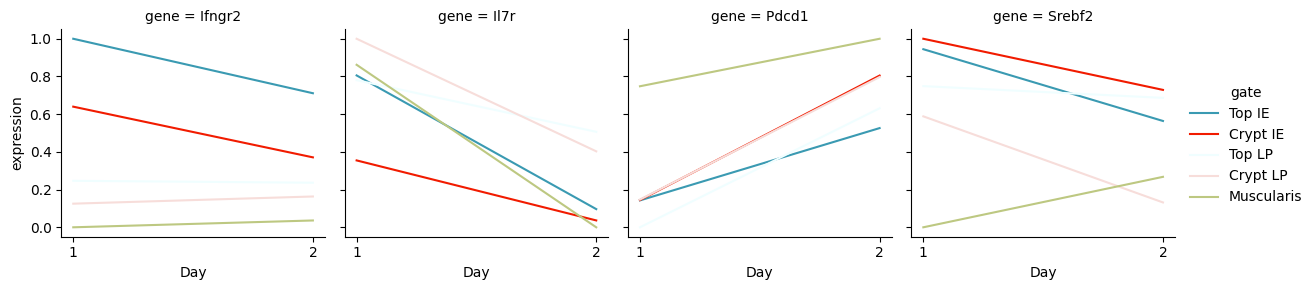

In [33]:
#df = get_scaled_mean_expression(p14_ab_Xist_adata, ["Tcf7", "Itgae", "Gzma", "Gzmb"])
df = get_scaled_mean_expression(p14_ab_Xist_adata, ["Il7r", "Srebf2", "Ifngr2", "Pdcd1"])
df_exhaustion = get_scaled_mean_expression(p14_ab_Xist_adata, exhaustion_genes)
df_tpex = get_scaled_mean_expression(p14_ab_Xist_adata, tpex_genes)
df_tex = get_scaled_mean_expression(p14_ab_Xist_adata, tex_genes)
print("group sizes" + str(df['group_size'].unique()))
gate_order = list(gates)
df["gate"] = (
    df["gate"].astype("category").cat.set_categories(gate_order, ordered=True)
)
g = sns.FacetGrid(
    df,
    hue="gate",
    col="gene",
    col_wrap=4,
    palette={k: gates[k]["stroke"] for k in gates},
)
g.map(sns.lineplot, "Day", "expression", err_style="bars")
g.add_legend()

## Counts by Batch

In [34]:
df["gate"] = (
    df["gate"]
    .astype("category")
    .cat.set_categories(gate_order, ordered=True)
)
df = df[df["group_size"] >= 10]

df.pivot(columns="gate", values="expression", index=["gene", "batch"])

gate              Top IE  Crypt IE    Top LP  Crypt LP  Muscularis
gene   batch                                                      
Ifngr2 batch_1  1.000000  0.639822  0.246599  0.125286    0.000000
       batch_2  0.711070  0.370981  0.236448  0.163398    0.036166
Il7r   batch_1  0.805523  0.354750  0.780408  1.000000    0.861907
       batch_2  0.096431  0.036417  0.506410  0.402893    0.000000
Pdcd1  batch_1  0.142755  0.144599  0.000000  0.147190    0.748048
       batch_2  0.526183  0.804693  0.631226  0.797003    1.000000
Srebf2 batch_1  0.944584  1.000000  0.748745  0.588410    0.000000
       batch_2  0.563969  0.728816  0.686518  0.131804    0.267624

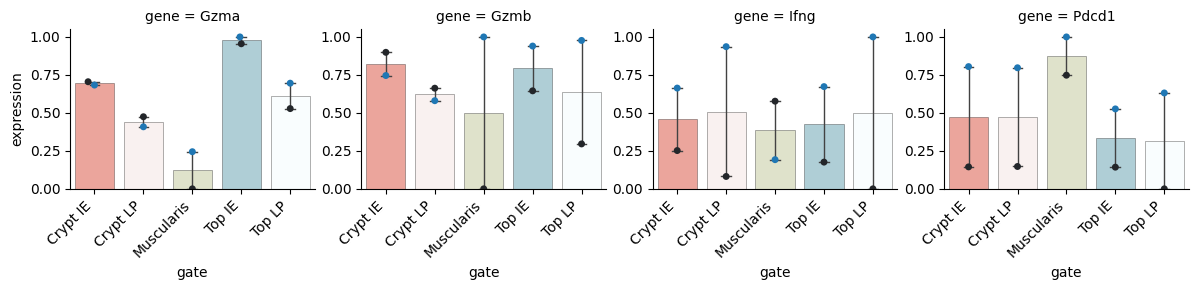

In [45]:
gate_palette = {
    "Top IE": "#3A9AB2",
    "Crypt IE": "#F11B00",
    "Top LP": "#F0FEFF",
    "Crypt LP": "#F7DDDA",
    "Muscularis": "#BDC881",
}

# g = sns.FacetGrid(df, col="gene", col_wrap=4, sharey=False)
# g = sns.FacetGrid(df_exhaustion, col="gene", col_wrap=4, sharey=False)
# g = sns.FacetGrid(df_tpex, col="gene", col_wrap=4, sharey=False)
g = sns.FacetGrid(df_tex, col="gene", col_wrap=4, sharey=False)
g.map_dataframe(
    sns.barplot,
    x="gate",
    y="expression",
    hue="gate",
    palette=gate_palette,
    alpha=0.44,
    capsize=0.2,
    edgecolor="black",
    linewidth=0.5,
    errwidth=1,
)
g.set_xticklabels(rotation=45, ha="right")
g.map_dataframe(sns.swarmplot, x="gate", y="expression", hue="batch")

In [36]:
print(df.shape)
print(df["gate"].unique())

(40, 6)
['Crypt IE', 'Crypt LP', 'Muscularis', 'Top IE', 'Top LP']
Categories (5, object): ['Top IE' < 'Crypt IE' < 'Top LP' < 'Crypt LP' < 'Muscularis']


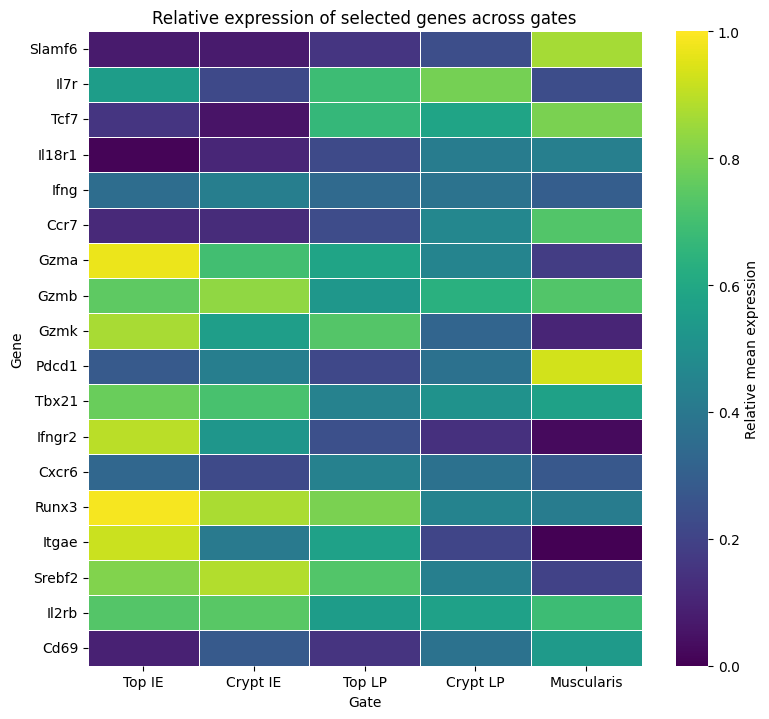

In [37]:
# Matrix plot of relative expression across gates for selected genes
genes_of_interest = [
    "Slamf6",
    "Il7r",
    "Tcf7",
    "Il18r1",
    "Ifng",
    "Ccr7",
    "Gzma",
    "Gzmb",
    "Gzmk",
    "Pdcd1",
    "Tbx21",
    "Ifngr2",
    "Cxcr6",
    "Runx3",
    "Itgae",
    "Srebf2",
    "Il2rb",
    "Cd69",
]

available_genes = [g for g in genes_of_interest if g in p14_ab_Xist_adata.var_names]
missing_genes = sorted(set(genes_of_interest) - set(available_genes))
if missing_genes:
    print(f"Skipping missing genes: {missing_genes}")

# Scaled mean expression by gate (scaled within each gene)
df_panel = get_scaled_mean_expression(p14_ab_Xist_adata, available_genes)

# Maybe: drop very small groups to reduce noise
#df_panel = df_panel[df_panel["group_size"] >= 10]

# Weighted average per gene/gate using group size as weight
df_gate_mean = (
    df_panel.groupby(["gene", "gate"])
    .apply(lambda g: np.average(g["expression"], weights=g["group_size"]))
    .reset_index(name="expression")
)

# Plot a heatmap compaaring relative gene expression across gates
heatmap_data = df_gate_mean.pivot(index="gene", columns="gate", values="expression")
heatmap_data = heatmap_data.reindex(index=available_genes, columns=gate_order)

plt.figure(figsize=(8, 0.35 * len(available_genes) + 1))
sns.heatmap(
    heatmap_data,
    cmap="viridis",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Relative mean expression"},
    vmin=0,
    vmax=1,
)
plt.xlabel("Gate")
plt.ylabel("Gene")
plt.title("Relative expression of selected genes across gates")
plt.tight_layout()
plt.show()



### Number of cells in each gate does not matter, only the mean expression of however many cells in each gate. Can compare on a gene by gene basis, not across genes.

In [38]:
import numpy as np
import pandas as pd
import itertools

regions = list(df_gate_mean["gate"].unique())
print("Regions:", regions)

# Pivot to gene x region matrix
expr_mat = df_gate_mean.pivot(index="gene", columns="gate", values="expression")

# Keep only genes of interest (available_genes) and discovered regions
expr_mat = expr_mat.reindex(index=available_genes, columns=regions)

# Optional: drop genes missing any region value (safer for contrasts)
expr_mat = expr_mat.dropna(axis=0, how="any")

# Compute all pairwise region-to-region contrasts
pairs = list(itertools.combinations(regions, 2))

contrast_wide = pd.DataFrame(index=expr_mat.index)
for a, b in pairs:
    contrast_wide[f"{a} - {b}"] = expr_mat[a] - expr_mat[b]

# One-number summary per gene (overall spatial separation within this experiment)
contrast_wide["contrast_norm"] = np.sqrt((contrast_wide**2).sum(axis=1))

# Long format (useful for plotting/merging across experiments)
contrast_long = (
    contrast_wide.reset_index()
    .melt(id_vars="gene", var_name="contrast", value_name="delta_expression")
)

display(contrast_wide)
display(contrast_long)


Regions: ['Crypt IE', 'Crypt LP', 'Muscularis', 'Top IE', 'Top LP']


,Crypt IE - Crypt LP,Crypt IE - Muscularis,Crypt IE - Top IE,Crypt IE - Top LP,Crypt LP - Muscularis,Crypt LP - Top IE,Crypt LP - Top LP,Muscularis - Top IE,Muscularis - Top LP,Top IE - Top LP,contrast_norm
gene,,,,,,,,,,,
Slamf6,-0.162647,-0.792849,0.000867,-0.080014,-0.630202,0.163514,0.082633,0.793716,0.712835,-0.080881,1.495610
Il7r,-0.570773,-0.011687,-0.332106,-0.466220,0.559086,0.238666,0.104553,-0.320420,-0.454533,-0.134113,1.166747
Tcf7,-0.530570,-0.744862,-0.099572,-0.609626,-0.214293,0.430998,-0.079056,0.645290,0.135236,-0.510054,1.466512
Il18r1,-0.307287,-0.318700,0.099204,-0.116890,-0.011413,0.406491,0.190398,0.417904,0.201810,-0.216094,0.826550
Ifng,0.045349,0.128990,0.071999,0.084497,0.083641,0.026650,0.039148,-0.056991,-0.044493,0.012499,0.213638
Ccr7,-0.340900,-0.608471,0.007650,-0.108754,-0.267572,0.348550,0.232146,0.616121,0.499718,-0.116404,1.178211
Gzma,0.244286,0.517321,-0.275230,0.110604,0.273035,-0.519516,-0.133682,-0.792551,-0.406717,0.385834,1.311496
Gzmb,0.200581,0.104267,0.084294,0.306712,-0.096314,-0.116287,0.106132,-0.019973,0.202445,0.222418,0.526496
Gzmk,0.230860,0.453027,-0.315679,-0.179140,0.222167,-0.546538,-0.410000,-0.768705,-0.632167,0.136538,1.384060


,gene,contrast,delta_expression
0,Slamf6,Crypt IE - Crypt LP,-0.162647
1,Il7r,Crypt IE - Crypt LP,-0.570773
2,Tcf7,Crypt IE - Crypt LP,-0.530570
3,Il18r1,Crypt IE - Crypt LP,-0.307287
4,Ifng,Crypt IE - Crypt LP,0.045349
...,...,...,...
193,Runx3,contrast_norm,1.149174
194,Itgae,contrast_norm,1.573137
195,Srebf2,contrast_norm,1.292681
196,Il2rb,contrast_norm,0.404868


In [39]:
contrast_long['gene'].unique()

array(['Slamf6', 'Il7r', 'Tcf7', 'Il18r1', 'Ifng', 'Ccr7', 'Gzma', 'Gzmb',
       'Gzmk', 'Pdcd1', 'Tbx21', 'Ifngr2', 'Cxcr6', 'Runx3', 'Itgae',
       'Srebf2', 'Il2rb', 'Cd69'], dtype=object)

In [40]:
# Export contrast_long to CSV
out_path_long = "clone13_contrast_long.csv"
contrast_long.to_csv(out_path_long, index=False)
print(f"saved {len(contrast_long)} rows to {out_path_long}")

out_path_wide = "clone13_contrast_wide.csv"
contrast_wide.to_csv(out_path_wide, index=False)
print(f"saved {len(contrast_wide)} rows to {out_path_wide}")


saved 198 rows to clone13_contrast_long.csv
saved 18 rows to clone13_contrast_wide.csv


# Clustering

In [41]:
t_cell_genes = pd.read_csv('/mnt/sata2/alex_storage/Desktop/kennidy/Prostate_Spatial_R2/04_T_Cell_gene_removal/T_Cell_Filtered.csv')
adata = adata[:, [i for i in adata.var.index if i in t_cell_genes.values.flatten()]]
t_cell_genes

,Unnamed: 0
0,Adam17
1,Adrb1
2,Adrb2
3,Ahr
4,Ankrd37
...,...
153,Top2a
154,Trbc1
155,Vps37b
156,Vta1


(674090, 34)
(7422, 34)


2026-02-05 16:16:55.806396: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-05 16:16:55.827901: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-05 16:16:56.356567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


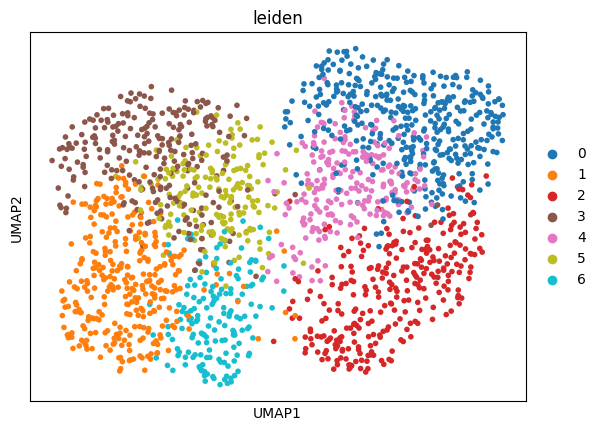

In [42]:
adata = sc.read_h5ad('/mnt/sata1/Dhruv_Analysis_1/2025_10_31_Clone13/combined/final_adata.h5ad')

adata.obs['Subtype'] = adata.obs['resolvi_predicted']

# Normalize and log transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Filter cells for Xist expression and P14 & ab+ Cd8 T cells
gidx = adata.var_names.get_loc('Xist')
X = adata.X
if sp.issparse(X):
    mask = X[:, gidx].toarray().ravel() > 0
else:
    mask = X[:, gidx] > 0

adata_xist = adata[mask].copy()
print(adata.obs.shape)
print(adata_xist.obs.shape)

p14_ab_Xist_adata = adata_xist[adata_xist.obs['Subtype'].isin(['Cd8_T-Cell_P14', 'Cd8_T-Cell_ab+'])]

p14_ab_Xist_adata = p14_ab_Xist_adata[:, p14_ab_Xist_adata.var_names.isin(t_cell_genes['Unnamed: 0'])]

p14_ab_Xist_adata
sc.pp.neighbors(p14_ab_Xist_adata, use_rep="X_scVI")
sc.tl.leiden(p14_ab_Xist_adata)
sc.tl.umap(p14_ab_Xist_adata)

sc.pl.embedding(p14_ab_Xist_adata, basis="umap", color="leiden", palette="tab10")

         Falling back to preprocessing with `sc.pp.pca` and default params.


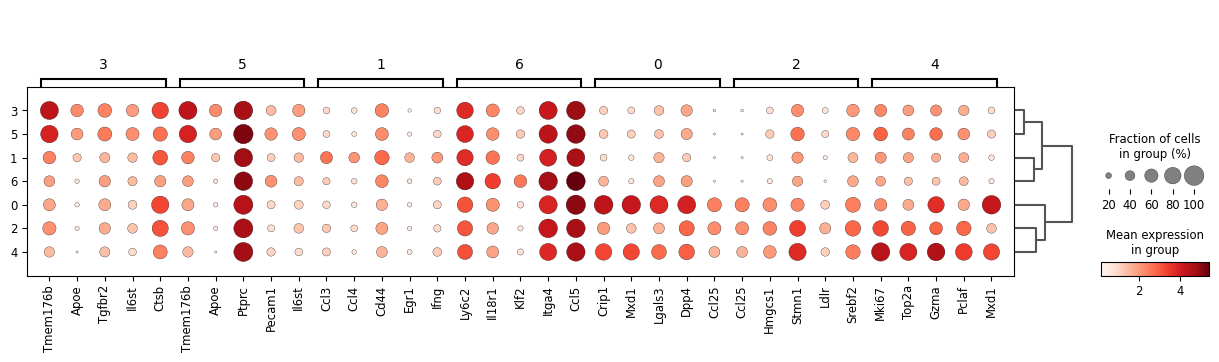

In [43]:
sc.tl.rank_genes_groups(p14_ab_Xist_adata, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(p14_ab_Xist_adata, groupby="leiden", n_genes=5)